In [1]:
from pylab import *
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import h5py
import ringdown
import matplotlib.pyplot as plt
import scipy
import random

sns.set_context('notebook')
sns.set_palette('colorblind')

In [2]:
#Functions used in the code
def norm(arr1,arr2):
    diff = arr1[1] - arr1[0]
    func = scipy.interpolate.interp1d(arr1,arr2)
    nor = 0
    for i in range(0,(len(arr1)-1)):
        diff1 = diff/4
        p1 = func(arr1[i])
        p2 = func(arr1[i]+(diff1))
        p3 = func(arr1[i]+(2*diff1))
        p4 = func(arr1[i]+(3*diff1))
        p5 = func(arr1[i+1])
        nor = nor+((2*diff)/45)*((7*p1)+(32*p2)+(12*p3)+(32*p4)+(7*p5))
    return nor 

def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain

def next_pow_two(x):
    y = 1
    while y < x:
        y = y << 1
    return y

In [3]:
#Input parameters
M_est = 70.0
chi_est = 0.7
tgps = 1126259462.4083147
right_ascension = 1.95
declination = -1.27
psi_in = 0.82
h1_ringdown = 'H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5'
l1_ringdown = 'L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5'
inspiral_data = '/nasdata1/ashwin.girish/downsampled_posterior_samples_v1.0.0/GW150914_downsampled_posterior_samples.dat'

In [4]:
h_raw_strain = read_strain(h1_ringdown, 'H1')
l_raw_strain = read_strain(l1_ringdown, 'L1')

longest_tau = ringdown.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/ringdown.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

T = 10*longest_tau
srate = next_pow_two(2*highest_drate)
print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 708.4 Hz
The time constant of the first tone is: 4.3 ms
Segment of 42.7 ms at sample rate 2048


In [5]:
#Choosing Ringdown model and conditioning data
fit = ringdown.Fit(model='mchi', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])  # use model='ftau' to fit damped sinusoids instead of +/x polarized GW modes
fit.add_data(h_raw_strain)
fit.add_data(l_raw_strain)
fit.set_target(tgps, ra=right_ascension, dec=declination, psi=psi_in, duration=T) #check if ra dec and psi are correct
fit.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=1/T)
fit.compute_acfs()
wd = fit.whiten(fit.analysis_data)

In [6]:
#Setting Priors and running fit
fit.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, flat_A=True)
fit.run(draws=12500,tune=5000,random_seed=1234)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
INFO:pymc:NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]


Sampling 4 chains for 5_000 tune and 12_500 draw iterations (20_000 + 50_000 draws total) took 293 seconds.
INFO:pymc:Sampling 4 chains for 5_000 tune and 12_500 draw iterations (20_000 + 50_000 draws total) took 293 seconds.


In [7]:
#Calculating final area 
m = np.array(fit.result.posterior.M)
spin = np.array(fit.result.posterior.chi)
mass = np.array([])
a = np.array([])
for i in range(0,4):
    mass = np.append(mass,m[i])
    a = np.append(a,spin[i])

G = 6.67 * (10**(-11))
c = 9 * (10**9)
area = [0 for i in range(0,len(mass))]
for i in range(0,len(mass)): 
    temp = 8*np.pi*(((G*mass[i])/(c**2))**2)*(1+((1-(a[i]**2))**(1/2)))
    area[i] = temp
area_f = np.array(area)

In [8]:
#Initial Areas
insp = np.genfromtxt(inspiral_data, dtype=float)
mass1 = np.array([insp[i][-10] for i in range(1,len(insp))])
mass2 = np.array([insp[i][-9] for i in range(1,len(insp))])
a1 = np.array([insp[i][2] for i in range(1,len(insp))])
a2 = np.array([insp[i][3] for i in range(1,len(insp))])

area1 = np.array([8*np.pi*(((G*mass1[i])/(c**2))**2)*(1+((1-(a1[i]**2))**(1/2))) for i in range(0,len(mass1))])
area2 = np.array([8*np.pi*(((G*mass2[i])/(c**2))**2)*(1+((1-(a2[i]**2))**(1/2))) for i in range(0,len(mass1))])
area_i = np.array([(area1[i] + area2[i]) for i in range(len(area1))]) #total initial area

In [81]:
#Gaussian KDES - Check how these look with different smoothening parameters and bandwidths
f2 = scipy.stats.gaussian_kde(area_i,bw_method='silverman') #KDE for initial area
f1 = scipy.stats.gaussian_kde(area_f,bw_method='silverman') #KDE for final area

N = 20 #Number of analysis points, I have taken fewer here, I take around 150 points when running on the cluster
start = 0.30000*1e-55
finish = 3.00000*1e-55 
u = np.linspace(start,finish,N)

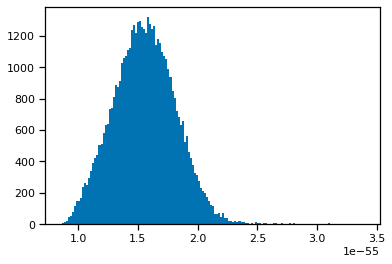

In [82]:
n,b,patches = plt.hist(area_f,bins=150)
n = np.append(n,0)
n = n*1e52*1.1 #Arbitrary scaling just for visualising data, no use in further calculations

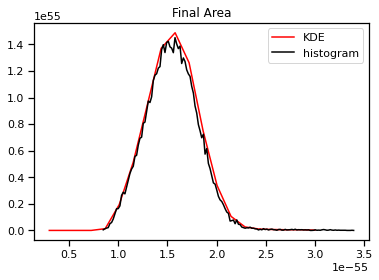

In [83]:
plt.plot(u,f1.evaluate(u),label='KDE',color='r')
plt.plot(b,n,label='histogram',color='k')
plt.legend()
plt.title('Final Area')
plt.show()

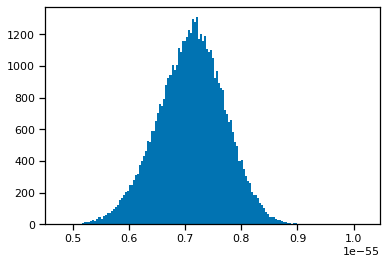

In [86]:
n,b,patches = plt.hist(area_i,bins=150)
n = np.append(n,0)
n = n*1e53/2 #Arbitrary scaling just for visualising data, no use in further calculations

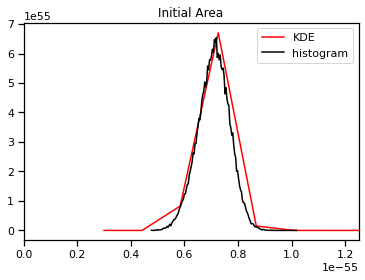

In [87]:
plt.plot(u,f2.evaluate(u),label='KDE',color='r')
plt.plot(b,n,label='histogram',color='k')
plt.legend()
plt.title('Initial Area')
plt.xlim(0,1.25e-55)
plt.show()

In [91]:
#Integral for A_f/A_i ratio
s = 0.0
f = 6.0 
I = [0.0 for i in range(0,10*N)] #z is the array of ratios, I is the pdf
z = np.linspace(s,f,10*N)
x = u
h = (u[1]-u[0])/len(x)

for i in range(0,len(z)):
    for j in range(0,(len(x)-1)):
        h1 = h/4
        k1 = f1.evaluate(x[j]*z[i]) * f2.evaluate(x[j]) * x[j]
        k2 = f1.evaluate((x[j]+(h1))*z[i]) * f2.evaluate(x[j]+(h1)) * (x[j]+(h1))
        k3 = f1.evaluate((x[j]+(2*h1))*z[i]) * f2.evaluate(x[j]+(2*h1)) * (x[j]+(2*h1))
        k4 = f1.evaluate((x[j]+(3*h1))*z[i]) * f2.evaluate(x[j]+(3*h1)) * (x[j]+(3*h1))
        k5 = f1.evaluate(x[j+1]*z[i]) * f2.evaluate(x[j+1]) * x[j+1]
        I[i] = I[i] + ((2*h)/45)*((7*k1)+(32*k2)+(12*k3)+(32*k4)+(7*k5))

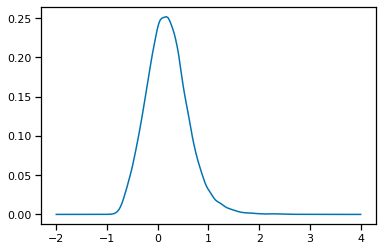

In [95]:
z = z - 1
# Normalising dA/A distribution
temp = np.array([])
for i in I:
    temp = np.append(temp,i)
I = temp
normal = norm(z,I)
I = I/normal

#Plotting dA/A and exporting data to a file
plt.plot(z,I)
plt.show()